In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, make_blobs
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

数据集形状: (150, 4)
特征名称: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
目标类别: ['setosa' 'versicolor' 'virginica']


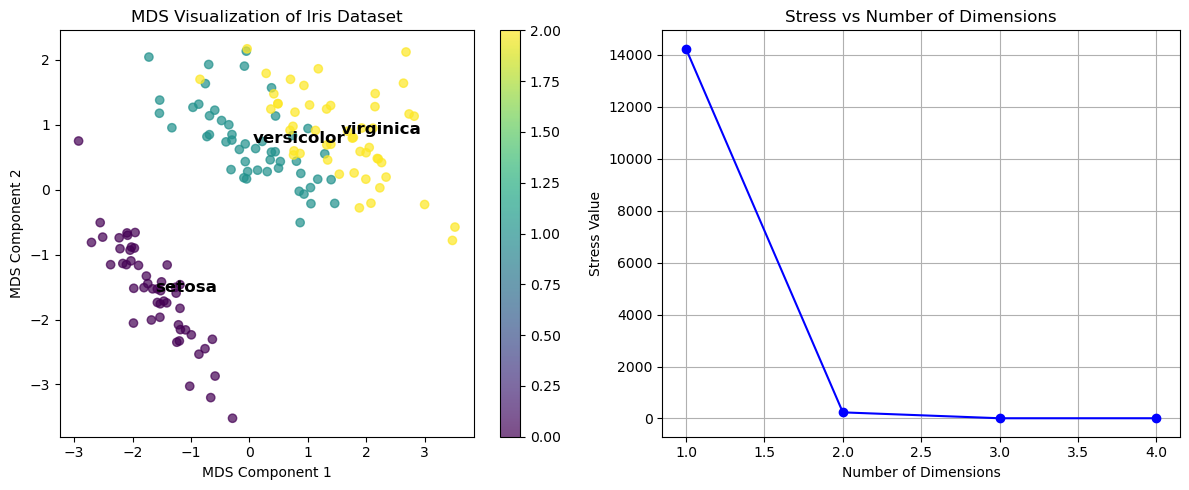

最终应力值 (2D): 235.4124
解释的方差比例: 0.9895


In [2]:
def basic_mds_analysis():
    """基础MDS分析 - 鸢尾花数据集"""
    # 加载数据
    iris = load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names
    target_names = iris.target_names
    
    print("数据集形状:", X.shape)
    print("特征名称:", feature_names)
    print("目标类别:", target_names)
    
    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 应用MDS
    mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
    X_mds = mds.fit_transform(X_scaled)
    
    # 可视化结果
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('MDS Visualization of Iris Dataset')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    
    # 添加类别标签
    for i, target_name in enumerate(target_names):
        plt.text(X_mds[y==i, 0].mean(), X_mds[y==i, 1].mean(), 
                target_name, fontsize=12, fontweight='bold')
    
    plt.subplot(1, 2, 2)
    # 绘制应力图（stress plot）来评估MDS质量
    stress_values = []
    dimensions = range(1, 5)
    
    for n_dim in dimensions:
        mds_temp = MDS(n_components=n_dim, random_state=42, normalized_stress='auto')
        mds_temp.fit(X_scaled)
        stress_values.append(mds_temp.stress_)
    
    plt.plot(dimensions, stress_values, 'bo-')
    plt.title('Stress vs Number of Dimensions')
    plt.xlabel('Number of Dimensions')
    plt.ylabel('Stress Value')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"最终应力值 (2D): {mds.stress_:.4f}")
    print(f"解释的方差比例: {1 - mds.stress_/(X_scaled.shape[0]**2):.4f}")

# 运行基础案例
basic_mds_analysis()

原始距离矩阵:
[[   0 1318 2126 2150 1552 1100]
 [1318    0 1375 1450 1660 1350]
 [2126 1375    0  140 1290 1500]
 [2150 1450  140    0 1320 1520]
 [1552 1660 1290 1320    0  600]
 [1100 1350 1500 1520  600    0]]


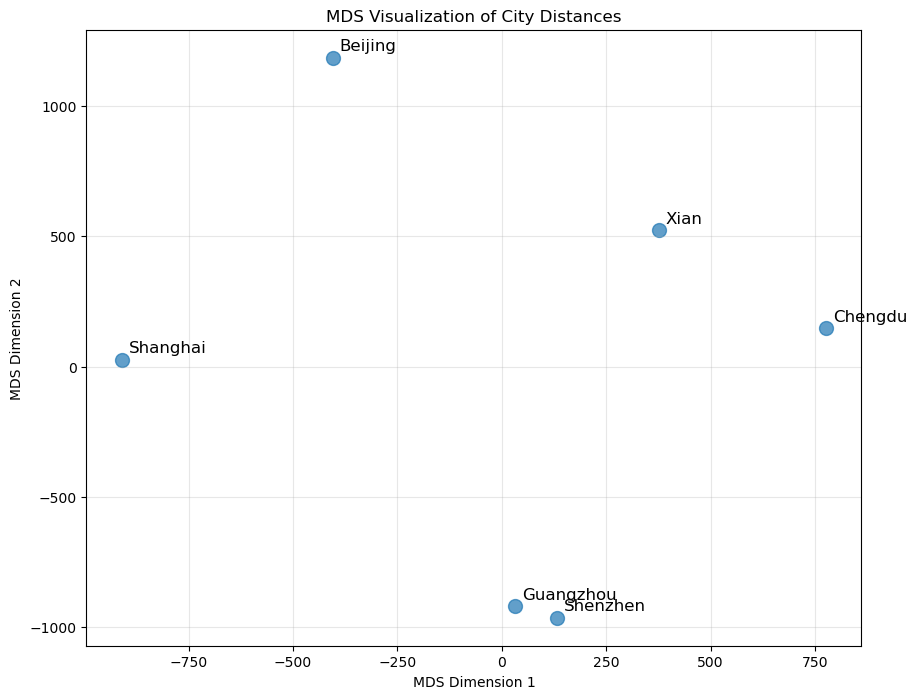

重建误差: 1266.5532
应力值: 22799.5469


In [3]:
def distance_based_mds():
    """基于自定义距离矩阵的MDS分析"""
    
    # 创建示例数据 - 城市间的距离
    cities = ['Beijing', 'Shanghai', 'Guangzhou', 'Shenzhen', 'Chengdu', 'Xian']
    
    # 模拟城市间的距离矩阵（公里）
    distance_matrix = np.array([
        [0, 1318, 2126, 2150, 1552, 1100],    # Beijing
        [1318, 0, 1375, 1450, 1660, 1350],    # Shanghai
        [2126, 1375, 0, 140, 1290, 1500],     # Guangzhou
        [2150, 1450, 140, 0, 1320, 1520],     # Shenzhen
        [1552, 1660, 1290, 1320, 0, 600],     # Chengdu
        [1100, 1350, 1500, 1520, 600, 0]      # Xian
    ])
    
    print("原始距离矩阵:")
    print(distance_matrix)
    
    # 使用距离矩阵进行MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
    coordinates = mds.fit_transform(distance_matrix)
    
    # 可视化城市位置
    plt.figure(figsize=(10, 8))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], s=100, alpha=0.7)
    
    # 添加城市标签
    for i, city in enumerate(cities):
        plt.annotate(city, (coordinates[i, 0], coordinates[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=12)
    
    plt.title('MDS Visualization of City Distances')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 评估重建质量
    reconstructed_distances = squareform(pdist(coordinates))
    reconstruction_error = np.mean((distance_matrix - reconstructed_distances) ** 2)
    
    print(f"重建误差: {reconstruction_error:.4f}")
    print(f"应力值: {mds.stress_:.4f}")
    
    return coordinates, cities

# 运行距离矩阵案例
city_coords, city_names = distance_based_mds()

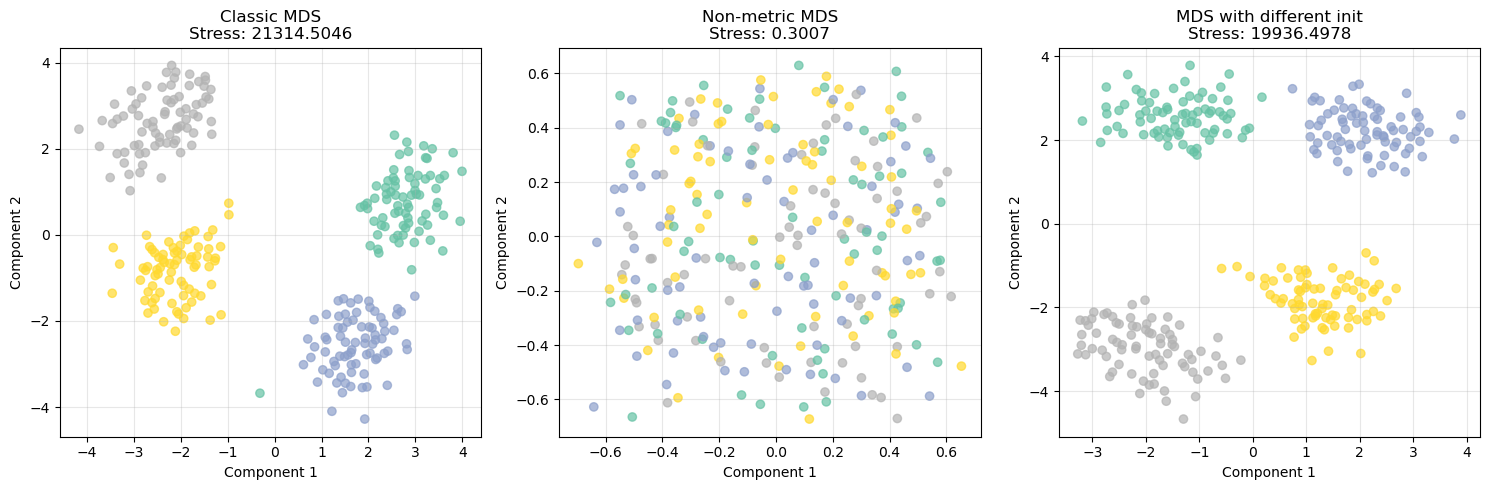


MDS算法比较:
                    Method      Stress  Iterations  Converged
0              Classic MDS  21314.5046          80       True
1           Non-metric MDS      0.3007           2       True
2  MDS with different init  19936.4978         135       True


In [4]:
def compare_mds_algorithms():
    """比较经典MDS和度量MDS"""
    
    # 生成复杂数据集
    X, y = make_blobs(n_samples=300, centers=4, n_features=10, 
                      random_state=42, cluster_std=2.0)
    
    # 标准化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 不同MDS配置
    mds_configs = {
        'Classic MDS': MDS(n_components=2, metric=True, random_state=42, normalized_stress='auto'),
        'Non-metric MDS': MDS(n_components=2, metric=False, random_state=42, normalized_stress='auto'),
        'MDS with different init': MDS(n_components=2, n_init=10, max_iter=500, 
                                     random_state=42, normalized_stress='auto')
    }
    
    # 可视化比较
    plt.figure(figsize=(15, 5))
    
    for idx, (name, mds) in enumerate(mds_configs.items()):
        X_transformed = mds.fit_transform(X_scaled)
        
        plt.subplot(1, 3, idx+1)
        scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], 
                             c=y, cmap='Set2', alpha=0.7)
        plt.title(f'{name}\nStress: {mds.stress_:.4f}')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 性能比较表格
    comparison_data = []
    for name, mds in mds_configs.items():
        X_temp = mds.fit_transform(X_scaled)
        stress = mds.stress_
        comparison_data.append({
            'Method': name,
            'Stress': f'{stress:.4f}',
            'Iterations': mds.n_iter_,
            'Converged': mds.n_iter_ < mds.max_iter
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\nMDS算法比较:")
    print(comparison_df)

# 运行算法比较
compare_mds_algorithms()

PCA 支持transform方法
Isomap 支持transform方法
LLE 支持transform方法


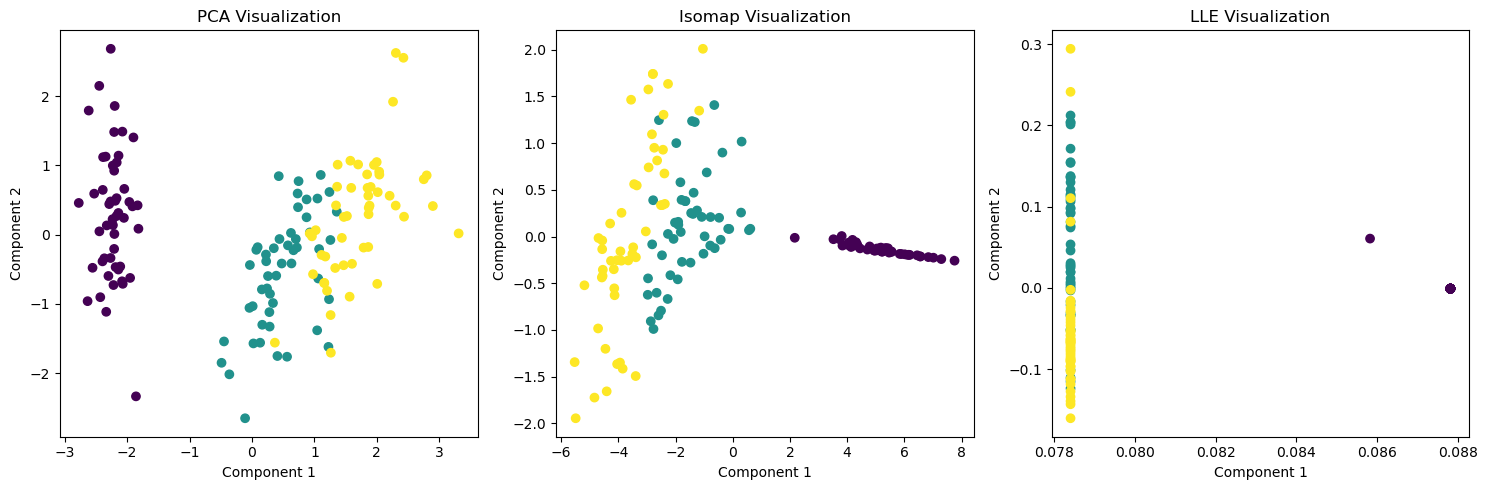

In [9]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA

def alternative_methods_with_transform():
    """使用支持transform的替代方法"""
    
    iris = load_iris()
    X = iris.data
    y = iris.target
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    methods = {
        'PCA': PCA(n_components=2, random_state=42),
        'Isomap': Isomap(n_components=2),
        'LLE': LocallyLinearEmbedding(n_components=2, random_state=42)
    }
    
    plt.figure(figsize=(15, 5))
    
    for idx, (name, model) in enumerate(methods.items()):
        # 训练模型
        X_transformed = model.fit_transform(X_scaled)
        
        # 这些方法都支持transform新数据
        if hasattr(model, 'transform'):
            print(f"{name} 支持transform方法")
        
        plt.subplot(1, 3, idx+1)
        plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis')
        plt.title(f'{name} Visualization')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
    
    plt.tight_layout()
    plt.show()

# 运行替代方法
alternative_methods_with_transform()

客户数据统计摘要:
              age         income  spending_score   frequency     loyalty
count  200.000000     200.000000      200.000000  200.000000  200.000000
mean    44.454607   51987.578490       58.138327    8.026900    7.256503
std     13.624668   18404.040414       19.500325    3.058723    1.911866
min     18.000000   20000.000000       10.567110   -0.090660    2.152241
25%     34.423085   37883.249244       44.122431    5.880592    5.938198
50%     44.937122   51576.786976       58.448002    8.066787    7.261074
75%     52.512787   63744.622814       71.441765   10.055531    8.436632
max     80.000000  100000.000000      100.000000   15.897146   12.053865


D:\anaconda1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


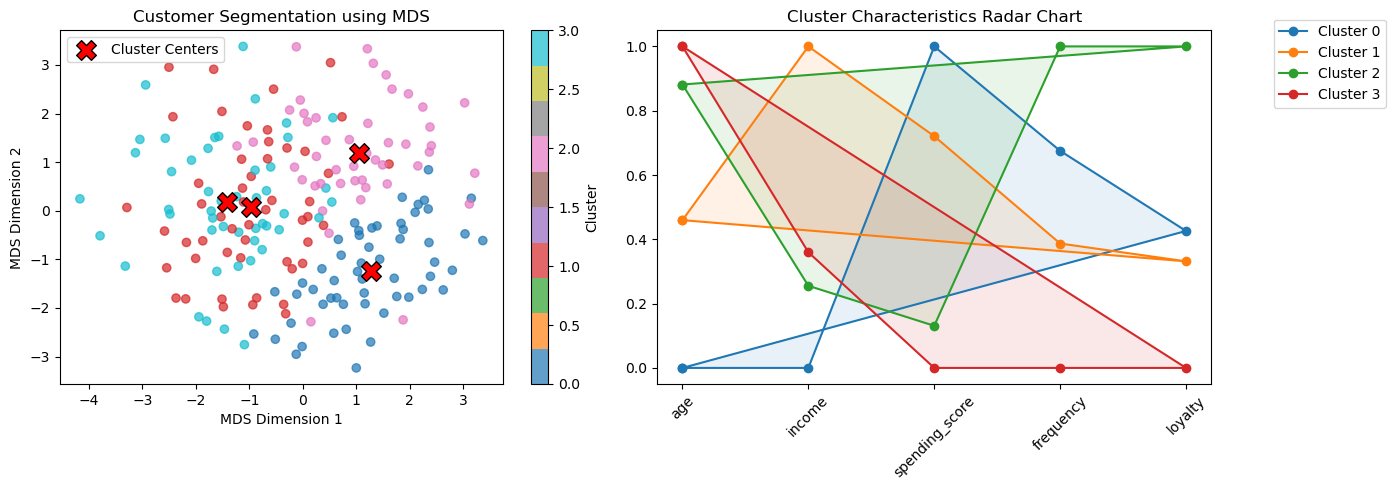

MDS应力值: 14451.7076
重建误差: 0.7225

各聚类统计特征:
               age        income  spending_score  frequency   loyalty
cluster                                                              
0        31.881274  37223.686175       68.466428   8.722652  7.237510
1        42.201250  74125.800053       62.822831   7.475685  6.920180
2        51.675199  46649.484062       50.905128  10.127865  9.164196
3        54.336011  50498.351850       48.258574   5.801925  5.807403

聚类特征分析:

聚类 0 (样本数: 55):
  平均年龄: 31.9
  平均收入: 37224
  平均消费分数: 68.5
  平均购买频率: 8.7
  平均忠诚度: 7.2

聚类 1 (样本数: 51):
  平均年龄: 42.2
  平均收入: 74126
  平均消费分数: 62.8
  平均购买频率: 7.5
  平均忠诚度: 6.9

聚类 2 (样本数: 46):
  平均年龄: 51.7
  平均收入: 46649
  平均消费分数: 50.9
  平均购买频率: 10.1
  平均忠诚度: 9.2

聚类 3 (样本数: 48):
  平均年龄: 54.3
  平均收入: 50498
  平均消费分数: 48.3
  平均购买频率: 5.8
  平均忠诚度: 5.8


In [12]:
def corrected_customer_segmentation_mds():
    """修正后的客户细分分析案例 - 解决transform问题"""
    
    # 模拟客户数据
    np.random.seed(42)
    n_customers = 200
    
    customer_data = {
        'age': np.random.normal(45, 15, n_customers),
        'income': np.random.normal(50000, 20000, n_customers),
        'spending_score': np.random.normal(60, 20, n_customers),
        'frequency': np.random.normal(8, 3, n_customers),
        'loyalty': np.random.normal(7, 2, n_customers)
    }
    
    df = pd.DataFrame(customer_data)
    df['age'] = np.clip(df['age'], 18, 80)
    df['income'] = np.clip(df['income'], 20000, 100000)
    df['spending_score'] = np.clip(df['spending_score'], 0, 100)
    
    print("客户数据统计摘要:")
    print(df.describe())
    
    # 数据标准化
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # 计算客户间的距离矩阵
    distance_matrix = euclidean_distances(scaled_data)
    
    # 应用MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', 
              random_state=42, normalized_stress='auto')
    customer_embeddings = mds.fit_transform(distance_matrix)
    
    # 使用KMeans进行客户分群
    from sklearn.cluster import KMeans
    
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    
    # **修正部分：正确计算聚类中心在MDS空间中的位置**
    # 方法：直接计算每个聚类在MDS空间中的均值
    centers_2d = []
    for i in range(4):
        cluster_points = customer_embeddings[clusters == i]
        if len(cluster_points) > 0:
            centers_2d.append(cluster_points.mean(axis=0))
        else:
            centers_2d.append([0, 0])  # 避免空聚类
    centers_2d = np.array(centers_2d)
    
    # 可视化结果
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(customer_embeddings[:, 0], customer_embeddings[:, 1], 
                         c=clusters, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Customer Segmentation using MDS')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    
    # 添加聚类中心
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='X', s=200, 
                label='Cluster Centers', edgecolors='black')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # 分析每个聚类的特征
    df['cluster'] = clusters
    cluster_means = df.groupby('cluster').mean()
    
    # 标准化聚类均值用于雷达图
    cluster_means_normalized = cluster_means.apply(
        lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0)
    
    angles = np.linspace(0, 2*np.pi, len(cluster_means.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    
    for cluster_idx in cluster_means_normalized.index:
        values = cluster_means_normalized.loc[cluster_idx].values.tolist()
        values += values[:1]  # 闭合雷达图
        plt.plot(angles, values, 'o-', label=f'Cluster {cluster_idx}')
        plt.fill(angles, values, alpha=0.1)
    
    plt.xticks(angles[:-1], cluster_means.columns, rotation=45)
    plt.title('Cluster Characteristics Radar Chart')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.show()
    
    # 评估MDS质量
    reconstructed_distances = squareform(pdist(customer_embeddings))
    reconstruction_error = np.mean((distance_matrix - reconstructed_distances) ** 2)
    
    print(f"MDS应力值: {mds.stress_:.4f}")
    print(f"重建误差: {reconstruction_error:.4f}")
    print("\n各聚类统计特征:")
    print(cluster_means)
    
    # 分析每个聚类的特点
    print("\n聚类特征分析:")
    for cluster_id in range(4):
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\n聚类 {cluster_id} (样本数: {len(cluster_data)}):")
        print(f"  平均年龄: {cluster_data['age'].mean():.1f}")
        print(f"  平均收入: {cluster_data['income'].mean():.0f}")
        print(f"  平均消费分数: {cluster_data['spending_score'].mean():.1f}")
        print(f"  平均购买频率: {cluster_data['frequency'].mean():.1f}")
        print(f"  平均忠诚度: {cluster_data['loyalty'].mean():.1f}")
    
    return customer_embeddings, clusters, centers_2d, df

# 运行修正后的客户细分案例
customer_embeddings, clusters, centers, df_with_clusters = corrected_customer_segmentation_mds()